# 設定


In [1]:
#Library Setting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, f1_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from matplotlib.ticker import MaxNLocator
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report

# Set font properties so that traditional Chinese could be shown on the graphs
font = {'family': 'Microsoft JhengHei', 'weight': 'normal', 'size': 12}
# Set font properties for all plots
plt.rc('font', **font)

# Turn off warnings
simplefilter("ignore")

# Part 1 : 載入資料

In [2]:
'''
from google.colab import drive
drive.mount('/content/drive')
# 請輸入放excel的路徑
import os
os.chdir('/content/drive/MyDrive/traffic processing time') # 更改路徑
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n# 請輸入放excel的路徑\nimport os\nos.chdir('/content/drive/MyDrive/traffic processing time') # 更改路徑\n"

資料說明:

1.「age」「height」「weight_data」為連續變數，其他為類別變數

2.For 類別變數: Default: 0=否,1=是

*「education (x)」: 1=不識字,2=國小,3=國中,4=高中,5=大學,6=研究所,7=其他

*「gender」: 0=女,1=男



In [3]:
# Data Part
df = pd.read_excel('最終數據.xlsx')

# Set 'record_id' as index
if df.index.name != 'record_id':
    df.set_index('record_id', inplace=True)

# Set NaN value to 0
df = df.fillna(0)

# Set Column 'baseline_monthly 每個月收入多少' to 1 or 0
df.loc[df['baseline_monthly 每個月收入多少'] != 2, 'baseline_monthly 每個月收入多少'] = 0 
df.loc[df['baseline_monthly 每個月收入多少'] == 2, 'baseline_monthly 每個月收入多少'] = 1

# filtered out those rows with column 'enroll' or 'follow1(是否活著)' as 0
df = df[~((df['enroll'] == 0) | (df['follow1(是否活著)']==0))]

# drop two columns that aren't relevant to 
df.drop(['enroll', 'follow1(是否活著)'], axis=1, inplace=True)

# Part 2 : 資料預覽

In [4]:
# Show a few rows
display(df.head())

,gender (x),age (x),height (x),weight_data (x),education (x),living___1 (x),osteoporosis_judge_o 是否骨質疏鬆,vivifrail_judge3 (x) SPPB分數是否大於9分,mna_score (x),menopause 早發性停經< 45歲 (x),...,sarcopenia_diagnosis 是否確診肌少症(X),calf_judge 小腿圍是否不足(X),hand_strength_judge 手握力是否不足(X),sit_and_stand_up_judge 起立坐下,sixm_sec_judge 6公尺步行速度太慢 (超過6秒),sarcopenia_judge 是否有肌肉質量不足(x),兩者髖關節是否不正常合(X),兩者骨頸是否不正常(X),dxa_spinet_n 腰椎T值是否不正常,(每年更新)fx 骨折
record_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,69.0,165.0,65.4,5.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0.0,0,0,0,0,0.0,0.0
2,1.0,82.4,164.0,67.2,1.0,0.0,1.0,1.0,1.0,0.0,...,0,1,0,0.0,0,0,0,0,0.0,0.0
4,0.0,69.6,155.0,60.7,1.0,0.0,0.0,1.0,1.0,1.0,...,0,1,0,1.0,0,0,0,0,1.0,0.0
5,0.0,64.1,152.0,62.1,4.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1.0,0,0,0,0,0.0,0.0
6,0.0,81.5,141.0,51.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,1,0,0.0,0,0,0,0,0.0,0.0


In [5]:
# Preview data
def DataPreview(df):
    print("**DataFrame Information:**")
    df.info()
    print("\n**Missing Values:**")
    print(df.isna().sum())
    print("\n**Duplicated Rows:**")
    print(df.duplicated().sum())
    print()

In [6]:
DataPreview(df)

**DataFrame Information:**
<class 'pandas.core.frame.DataFrame'>
Index: 469 entries, 1 to 634
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender (x)                         469 non-null    float64
 1   age (x)                            469 non-null    float64
 2   height (x)                         469 non-null    float64
 3   weight_data (x)                    469 non-null    float64
 4   education (x)                      469 non-null    float64
 5   living___1 (x)                     469 non-null    float64
 6   osteoporosis_judge_o 是否骨質疏鬆        469 non-null    float64
 7   vivifrail_judge3 (x) SPPB分數是否大於9分  469 non-null    float64
 8   mna_score (x)                      469 non-null    float64
 9   menopause 早發性停經< 45歲 (x)           469 non-null    float64
 10  baseline_monthly 每個月收入多少           469 non-null    float64
 11  frax_5(骨折史)                        4

根據資料規則的理解，總共有 469 個樣本。我們也為每一欄設定正確的資料類型（我們不將某些特徵指定為分類變量，因為之後還是得進行轉換。）且確定沒有缺失值和樣本重複的狀況。接著我們可以繼續預處理這些樣本。

# Part 3 : 資料預處理

In [7]:
# Write a class for feature selection
class DataPreProcess:
    def __init__(self): # Define some common attributes in the class
        pass

In [8]:
# X is a df that contains multiple features
def FeatureProcessing(self, X , review = None):
    # Set the display option to show all columns (In case there are columns being truncated when there are lots of columns)
    pd.options.display.max_columns = None
    
    # Print the number of unique value of each column
    df_unique_value = pd.DataFrame(index = ['Num_unique_vals',] , columns = X.columns)
    for column in X.columns:
        df_unique_value.at['Num_unique_vals',column] = X[column].nunique()
    print('\033[1mHere is the number of unique values of each columns :\033[0m')
    display(df_unique_value)

    # Print all the column names of categorical data that need transformation.
    categorical_colnames = X.select_dtypes(include=['object','category']).columns.values
    print(f'\n\033[1mThe columns of categorical data are :\033[0m \n {categorical_colnames}')

    # Check if all variables aren't either categorical or object, if yes then label encode those variables.
    for colname in X.select_dtypes(include=['object','category']):
        X[colname], _ = X[colname].factorize()

    # (optional) review after factorization if designated
    if review == True:
        print("\n\033[1mHere is the transformed dataframe :\033[0m")
        display(X.head())
        # Print all the column names of categorical data that need transformation.
        categorical_colnames = X.select_dtypes(include=['object','category']).columns.values
        print(f'\n\033[1mAfter transformation, the columns of categorical data are :\033[0m \n {categorical_colnames}')
        
    # Reset the display option to default
    pd.reset_option('display.max_columns')

# Add the method to the class FeatureSelector
DataPreProcess.FeatureProcessing = FeatureProcessing

In [9]:
DPP = DataPreProcess()
DPP.FeatureProcessing(df,review = True)

Here is the number of unique values of each columns :


,gender (x),age (x),height (x),weight_data (x),education (x),living___1 (x),osteoporosis_judge_o 是否骨質疏鬆,vivifrail_judge3 (x) SPPB分數是否大於9分,mna_score (x),menopause 早發性停經< 45歲 (x),baseline_monthly 每個月收入多少,frax_5(骨折史),frax_7(目前吸菸),frax_11 是否過度飲酒,frax_6 父母骨折史,frax_10 次發性骨鬆,frax_9 類風溼性關節炎,dm 是否有糖尿病,exercise,(每年更新)follow_2 是否有跌倒,sarcopenia_diagnosis 是否確診肌少症(X),calf_judge 小腿圍是否不足(X),hand_strength_judge 手握力是否不足(X),sit_and_stand_up_judge 起立坐下,sixm_sec_judge 6公尺步行速度太慢 (超過6秒),sarcopenia_judge 是否有肌肉質量不足(x),兩者髖關節是否不正常合(X),兩者骨頸是否不正常(X),dxa_spinet_n 腰椎T值是否不正常,(每年更新)fx 骨折
Num_unique_vals,2,252,48,257,7,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2



The columns of categorical data are : 
 []

Here is the transformed dataframe :


,gender (x),age (x),height (x),weight_data (x),education (x),living___1 (x),osteoporosis_judge_o 是否骨質疏鬆,vivifrail_judge3 (x) SPPB分數是否大於9分,mna_score (x),menopause 早發性停經< 45歲 (x),baseline_monthly 每個月收入多少,frax_5(骨折史),frax_7(目前吸菸),frax_11 是否過度飲酒,frax_6 父母骨折史,frax_10 次發性骨鬆,frax_9 類風溼性關節炎,dm 是否有糖尿病,exercise,(每年更新)follow_2 是否有跌倒,sarcopenia_diagnosis 是否確診肌少症(X),calf_judge 小腿圍是否不足(X),hand_strength_judge 手握力是否不足(X),sit_and_stand_up_judge 起立坐下,sixm_sec_judge 6公尺步行速度太慢 (超過6秒),sarcopenia_judge 是否有肌肉質量不足(x),兩者髖關節是否不正常合(X),兩者骨頸是否不正常(X),dxa_spinet_n 腰椎T值是否不正常,(每年更新)fx 骨折
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,69.0,165.0,65.4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,0,0,0,0,0.0,0.0
2,1.0,82.4,164.0,67.2,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0.0,0,0,0,0,0.0,0.0
4,0.0,69.6,155.0,60.7,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,1.0,0,0,0,0,1.0,0.0
5,0.0,64.1,152.0,62.1,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,1.0,0,0,0,0,0.0,0.0
6,0.0,81.5,141.0,51.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0.0,0,0,0,0,0.0,0.0



After transformation, the columns of categorical data are : 
 []


到目前為止，我們已妥善處理每個儲存格。我們也確認了欄位應包含的值。
我們可以觀察到除了'age (x)','height (x)','weight_data (x)'外，其餘都是分類特徵。又在分類特徵中，'education (x)'具有7個可能值，須注意該欄位是名義數據而不是序數數據。

# Part 4 : 探索性分析 

In [10]:
# Set the columns as features or target
X = df.copy()
y = X.pop('(每年更新)fx 骨折')

In [11]:
# Write a class for feature selection
class ExploratoryAnalysis:
    def __init__(self): # Define some common attributes in the class
        pass

In [12]:
def DataInfo(self, df):
    # Set the display option to show all columns (In case there are columns being truncated when there are lots of columns)
    pd.options.display.max_columns = None

    # Calculate skewness, kurtosis, and coefficient of variation
    skew_val, kurt_val, cof_var = skew(df) ,kurtosis(df), df.std()/df.mean()

    # Create a df for skewness, kurtosis, and coefficient of variation
    df_stats = pd.DataFrame({'skewness': skew_val, 'kurtosis': kurt_val,'coefficient of variation': cof_var}).transpose()

    # Add df_stats to df.describe()
    description = pd.concat([df.describe(),df_stats],axis = 0)

    # Display the df
    print('\033[1mHere is the descriptive statistics each columns :\033[0m')
    display(description)
    
    # Reset the display option to default
    pd.reset_option('display.max_columns')
    
# Add the method to the class ExploratoryAnalysis
ExploratoryAnalysis.DataInfo = DataInfo

In [13]:
def TargetDist(self, y, Dtype = "Numerical"): # assume y is a series
    if Dtype == "Numerical":
        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
        
        #Turn y into DataFrame for easier operation
        df = pd.DataFrame(y)
        
        # Violin plot (Show the boxplot and the distribution)
        sns.violinplot(data=df.reset_index(drop=True),ax=axes[0,0])
        axes[0,0].set_title(f'Violin Plot')
        
        # Boxplot (Zoom in the boxplot within the violin plot and visualize the the number of outliers)
        sns.boxplot(y=y,ax=axes[0,1], showfliers=True)
        axes[0,1].set_title('Box Plot with outlier')
        axes[0,1].set_ylabel('')
        axes[0,1].set_xlabel(f'{y.name}')
        
        # Distribution plot (Visualize how tilted the distribution is)
        axes[1,0].plot(range(1,len(y)+1), y.sort_values(ascending = True))
        axes[1,0].set_title(f'Line Plot of {y.name} (ascending)')
        
        #QQ-Plot (Visualize the distribution against normal distribution)
        stats.probplot(y, dist="norm", plot=axes[1,1])
        axes[1,1].set_title(f'QQ Plot of {y.name} against normal distribution')
        axes[1,1].set_xlabel('Theoretical Quantiles')
        axes[1,1].set_ylabel('Sample Quantiles')
        
        # Show the plot
        print(f'\033[1mHere is the distribution plot of {y.name} :\033[0m')
        # Adjust layout
        plt.tight_layout()
        plt.show()
        
    if Dtype == "Categorical":
        # Plotting
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
        
        # Bar plot
        unique_values, value_counts = np.unique(y, return_counts=True)
        bars = axes[0].bar(unique_values, value_counts, color='skyblue')
        axes[0].set_xlabel('Value')
        axes[0].set_xticks(unique_values)
        axes[0].set_ylabel('Frequency')
        # Add labels on top of bars by calculating the position of each bar
        for bar, count in zip(bars, value_counts):
            axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),ha='center', va='bottom')
        axes[0].set_title(f'Bar chart of {y.name}')
        
        # Pie Plot
        percentage_counts = value_counts / value_counts.sum()
        axes[1].pie(percentage_counts, labels=unique_values, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'lightsalmon'], startangle=90)
        axes[1].set_title(f'Pie chart of {y.name}')
        axes[1].legend(loc='lower right')
        axes[1].axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle

        # Show the plot
        print(f'\033[1mHere is the distribution plot of {y.name} :\033[0m\n')
        # Adjust layout
        plt.tight_layout()
        plt.show()
        
# Add the method to the class ExploratoryAnalysis
ExploratoryAnalysis.TargetDist = TargetDist

In [14]:
EA = ExploratoryAnalysis()
EA.DataInfo(df)

Here is the descriptive statistics each columns :


,gender (x),age (x),height (x),weight_data (x),education (x),living___1 (x),osteoporosis_judge_o 是否骨質疏鬆,vivifrail_judge3 (x) SPPB分數是否大於9分,mna_score (x),menopause 早發性停經< 45歲 (x),baseline_monthly 每個月收入多少,frax_5(骨折史),frax_7(目前吸菸),frax_11 是否過度飲酒,frax_6 父母骨折史,frax_10 次發性骨鬆,frax_9 類風溼性關節炎,dm 是否有糖尿病,exercise,(每年更新)follow_2 是否有跌倒,sarcopenia_diagnosis 是否確診肌少症(X),calf_judge 小腿圍是否不足(X),hand_strength_judge 手握力是否不足(X),sit_and_stand_up_judge 起立坐下,sixm_sec_judge 6公尺步行速度太慢 (超過6秒),sarcopenia_judge 是否有肌肉質量不足(x),兩者髖關節是否不正常合(X),兩者骨頸是否不正常(X),dxa_spinet_n 腰椎T值是否不正常,(每年更新)fx 骨折
count,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000
mean,0.191898,74.279744,154.809168,59.260128,2.852878,0.208955,0.605544,0.767591,0.102345,0.100213,0.522388,0.149254,0.023454,0.014925,0.049041,0.159915,0.017058,0.238806,0.837953,0.296375,0.196162,0.484009,0.375267,0.452026,0.394456,0.447761,0.023454,0.006397,0.110874,0.042644
std,0.394214,8.619105,7.728523,10.284097,1.739958,0.406996,0.489255,0.422820,0.303426,0.300605,0.500032,0.356719,0.151502,0.121384,0.216183,0.366918,0.129624,0.426809,0.368887,0.457146,0.397517,0.500278,0.484709,0.498225,0.489255,0.497795,0.151502,0.079808,0.314312,0.202269
min,0.000000,51.400000,135.000000,30.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,68.800000,150.000000,52.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,74.300000,154.000000,58.800000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,80.200000,160.000000,65.100000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,96.100000,179.000000,96.200000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
skewness,1.564793,-0.193152,0.303306,0.458143,0.628532,1.431735,-0.431907,-1.267095,2.623899,2.662724,-0.089642,1.968613,6.297649,8.000947,4.176467,1.855718,7.459380,1.225245,-1.834240,0.891803,1.530313,0.063999,0.515224,0.192787,0.431907,0.210105,6.297649,12.383044,2.478695,4.527090
kurtosis,0.448578,-0.350857,-0.121635,0.667016,-0.946485,0.049865,-1.813456,-0.394470,4.884848,5.090098,-1.991964,1.875439,37.660381,62.015152,15.442874,1.443689,53.642354,-0.498775,1.364437,-1.204687,0.341858,-1.995904,-1.734545,-1.962833,-1.813456,-1.955856,37.660381,151.339771,4.143931,18.494543


Here is the distribution plot of (每年更新)fx 骨折 :



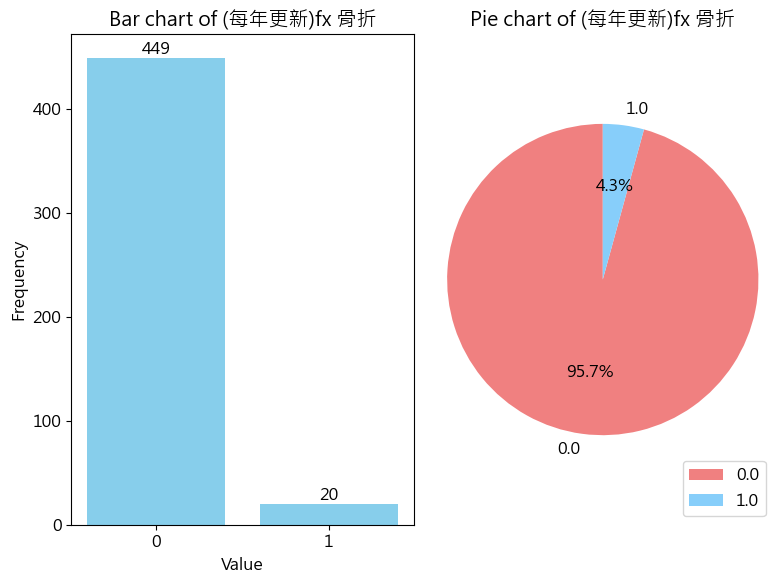

In [15]:
EA.TargetDist(df['(每年更新)fx 骨折'],"Categorical")

我們可以發現，我們的目標變數有樣本不均衡的問題(0的有96%，而1的只有4%)，這對於某些模型來說，會影響到預測為1的準確度，因此訓練前必須重新抽選樣本。

# Part 5 : 模型訓練

# Part 5-1 : 特徵篩選

In [16]:
# Split the data into train and test sets with stratification sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=30)

In [17]:
# Standardize the features (mean=0 and variance=1)
Columns = ['age (x)','height (x)','weight_data (x)']
scaler = StandardScaler()

# Get a copy of X_train and X_test
X_train_Standardized = X_train.copy() 
X_test_Standardized = X_test.copy()

# Fit and transform X_train and transform X_test based on the fit from X_train to prevent data leakage
X_train_Standardized[Columns] = scaler.fit_transform(X_train_Standardized[Columns])
X_test_Standardized[Columns] = scaler.transform(X_test_Standardized[Columns])

In [18]:
# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_Standardized)
logit_result = logit_model.fit()

# Print summary of the logistic regression model
print(logit_result.summary())

# Access p-values and odds ratios from the results
p_values = logit_result.pvalues
odds_ratios = np.exp(logit_result.params)

# Print p-values and odds ratios
print(f"\nP-values of {type(logit_model).__name__} model:")
print(p_values)
print(f"\nOdds Ratios {type(logit_model).__name__} model:")
print(odds_ratios)

         Current function value: 0.109295
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            (每年更新)fx 骨折   No. Observations:                  328
Model:                          Logit   Df Residuals:                      299
Method:                           MLE   Df Model:                           28
Date:                Sun, 12 May 2024   Pseudo R-squ.:                  0.3803
Time:                        03:45:46   Log-Likelihood:                -35.849
converged:                      False   LL-Null:                       -57.852
Covariance Type:            nonrobust   LLR p-value:                   0.02774
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
gender (x)                            0.1621      1.565      0.104      0.917      -2.905       3.

In [19]:
# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_Standardized, y_train)

# Access feature importance scores for decision tree
dt_feature_importance = dt_model.feature_importances_

print("Logistic Regression Feature Importance:")
for column, importance in zip(X_train_Standardized.columns,logit_result.params):
    print(f"{column} : {importance}")

print("\nDecision Tree Feature Importance:")
for column, importance in zip(X_train_Standardized.columns,dt_feature_importance):
    print(f"{column} : {importance}")

Logistic Regression Feature Importance:
gender (x) : 0.16211997057784164
age (x) : -0.2508854132996
height (x) : 0.4700926329327919
weight_data (x) : -0.05155623518471
education (x) : -0.5907565117558541
living___1 (x) : -0.5771066136541559
osteoporosis_judge_o 是否骨質疏鬆 : -0.5860009294936033
vivifrail_judge3 (x) SPPB分數是否大於9分 : -1.2448265094178241
mna_score (x) : -1.654881704416744
menopause 早發性停經< 45歲 (x) : -17.70848046404915
baseline_monthly 每個月收入多少 : -0.45730717901805584
frax_5(骨折史) : 0.15793094913807615
frax_7(目前吸菸) : 2.523116020766837
frax_11 是否過度飲酒 : -19.638889514895897
frax_6 父母骨折史 : -24.184176489321594
frax_10 次發性骨鬆 : 0.28545710498461513
frax_9 類風溼性關節炎 : -20.419760571149624
dm 是否有糖尿病 : 0.9578427496572357
exercise : -1.466725051485321
(每年更新)follow_2 是否有跌倒 : 3.324008243150864
sarcopenia_diagnosis 是否確診肌少症(X) : 20.12263983734211
calf_judge 小腿圍是否不足(X) : -1.6196896179762295
hand_strength_judge 手握力是否不足(X) : -19.80882232839249
sit_and_stand_up_judge 起立坐下 : -0.5172670854401306
sixm_sec_jud

In [20]:
def FS_RFECV(X_train,y_train,model,cv=5, step =1):
    # Create RFECV object with defeault step = 1 , cv = 5
    rfecv = RFECV(estimator = model, step=step, cv=cv)
    
    # Fit RFECV to training data
    rfecv.fit(X_train, y_train)

    # Get the selected features and names
    selected_features_names = X_train.columns[rfecv.support_].tolist()
    
    # Return the selected features and the optimal number of features
    print(f'\nThere are {rfecv.n_features_} selected features, including {selected_features_names}, for {type(model).__name__} model')
    # Store those feature into a new variable
    return selected_features_names

In [21]:
# Specify the models for feature selection
models = [LogisticRegression(),DecisionTreeClassifier()]

# Filter X_train and X_test with the selected feature names and store into a new variable
for model in models:
    # Store X_train and X_test with selected feature names into new variables
    selected_featurenames = FS_RFECV(X_train_Standardized, y_train,model)
    globals()[f'X_train_{type(model).__name__}'] = X_train[selected_featurenames]
    globals()[f'X_test_{type(model).__name__}'] = X_test[selected_featurenames]


There are 1 selected features, including ['(每年更新)follow_2 是否有跌倒'], for LogisticRegression model

There are 1 selected features, including ['age (x)'], for DecisionTreeClassifier model


# Part 5-2 : 模型參數微調

本次以Logistic Regression、Decision Tree、ANN三個模型進行優化，先透過交叉驗證做出最好的模型參數

In [22]:
# Input for CV
models = [LogisticRegression(),DecisionTreeClassifier(),MLPClassifier()]

# (ANN use selected feature of DecisionTreeClassifier)
X_trains_Selected = [X_train_LogisticRegression,X_train_DecisionTreeClassifier,X_train_DecisionTreeClassifier]
X_tests_Selected = [X_test_LogisticRegression,X_test_DecisionTreeClassifier,X_test_DecisionTreeClassifier]

param_grids = [
    {'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']},
    {'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]},
    {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]}]

In [23]:
def CV(X_train, X_test, y_train, y_test,model, param_grid,scoring,n_splits = 5,shuffle = True):
    # Cross-validate with stratified sampling, shuffle before sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle = shuffle, random_state=42)
    
    # Perform grid search with different cv value, use accura
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and corresponding score
    best_params = grid_search.best_params_
    best_train_score = grid_search.best_score_
    # Make predictions on the test set using the best model
    best_model = grid_search.best_estimator_
    # Calculate the score on the test set using the best model
    best_test_score = best_model.score(X_test, y_test)
    # Calculate the score difference of train score and test score
    best_score_diff = abs(best_train_score - best_test_score)
    
    # Print the best model and its score
    print(f"The attribute of the best model (greatest test Score) of {type(model).__name__}:")
    print(f"Model : {best_model}")
    print(f"Train Score : {best_train_score}")
    print(f"Test Score : {best_test_score}")
    print(f"Score Difference : {best_score_diff}")
    print()

    return best_model

以下選用accuracy做標準做交叉驗證

In [24]:
def ConfusionMatrix(X_train, X_test, y_train, y_test,best_model):
    # fit the train set with the best model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    confusion_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = ['Negative', 'Positive'])
    confusion_matrix.plot(cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    
    # Print classification report
    print("Classification Report:")
    print(report)

The attribute of the best model (greatest test Score) of LogisticRegression:
Model : LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
Train Score : 0.9573426573426573
Test Score : 0.9574468085106383
Score Difference : 0.00010415116798101476



<Figure size 600x400 with 0 Axes>

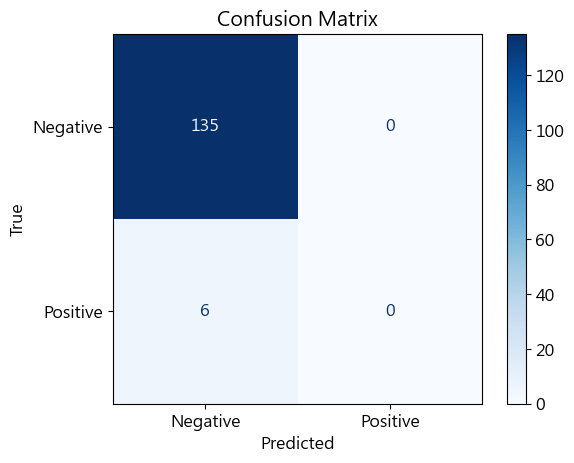

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       135
     Class 1       0.00      0.00      0.00         6

    accuracy                           0.96       141
   macro avg       0.48      0.50      0.49       141
weighted avg       0.92      0.96      0.94       141

The attribute of the best model (greatest test Score) of DecisionTreeClassifier:
Model : DecisionTreeClassifier(criterion='entropy', max_depth=5)
Train Score : 0.9482517482517483
Test Score : 0.950354609929078
Score Difference : 0.0021028616773297593



<Figure size 600x400 with 0 Axes>

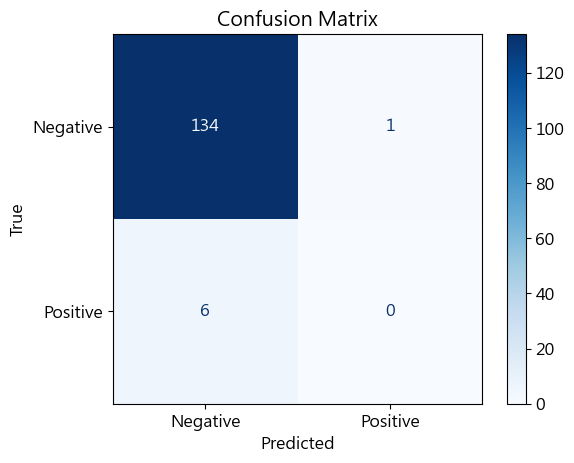

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       135
     Class 1       0.00      0.00      0.00         6

    accuracy                           0.95       141
   macro avg       0.48      0.50      0.49       141
weighted avg       0.92      0.95      0.93       141

The attribute of the best model (greatest test Score) of MLPClassifier:
Model : MLPClassifier(hidden_layer_sizes=(50,))
Train Score : 0.9573426573426573
Test Score : 0.9574468085106383
Score Difference : 0.00010415116798101476



<Figure size 600x400 with 0 Axes>

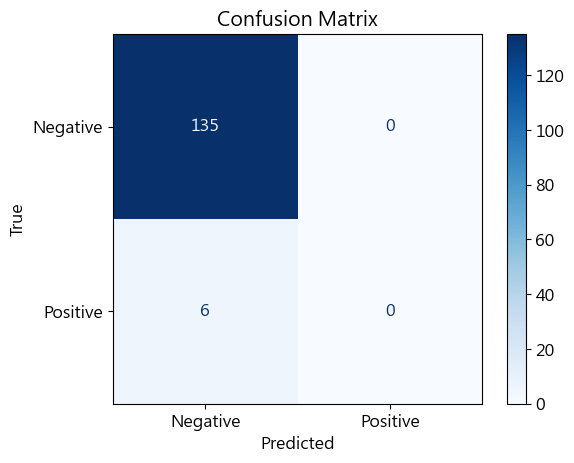

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       135
     Class 1       0.00      0.00      0.00         6

    accuracy                           0.96       141
   macro avg       0.48      0.50      0.49       141
weighted avg       0.92      0.96      0.94       141



In [25]:
# Put the combination of model and param_grid into function
for model, param_grid,X_train_Selected,X_test_Selected in zip(models,param_grids,X_trains_Selected,X_tests_Selected):
    best_model = CV(X_train_Selected,X_test_Selected, y_train, y_test, model, param_grid, 'accuracy')
    ConfusionMatrix(X_train_Selected,X_test_Selected, y_train, y_test, best_model)

以accuracy為標準，交叉驗證出DecisionTreeClassifier(max_depth=5, min_samples_split=10)是最好的model

# Part 6 : 模型檢驗

這邊將我們跑出最好的model : DecisionTreeClassifier(max_depth=5, min_samples_split=10)應用到原始資料跑一遍

In [26]:
# Split the original data into train and test sets with stratification sampling
X_train_Original, X_test_Original, y_train_Original, y_test_Original = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 30)

# Standardize the features (mean=0 and variance=1)
Columns = ['age (x)','height (x)','weight_data (x)']
scaler = StandardScaler()

# Get a copy of the original X_train and X_test
X_train_Original_Standardized = X_train_Original.copy() 
X_test_Original_Standardized = X_test_Original.copy()

# Fit and transform X_train and then transform X_test 
X_train_Original_Standardized[Columns] = scaler.fit_transform(X_train_Original_Standardized[Columns])
X_test_Original_Standardized[Columns] = scaler.transform(X_test_Original_Standardized[Columns])

# Filter X_train and X_test with the features selected for Decision Tree model
X_train_Original_Selected = X_train_Original_Standardized[X_train_DecisionTreeClassifier.columns.tolist()]
X_test_Original_Selected = X_test_Original_Standardized[X_test_DecisionTreeClassifier.columns.tolist()]

<Figure size 600x400 with 0 Axes>

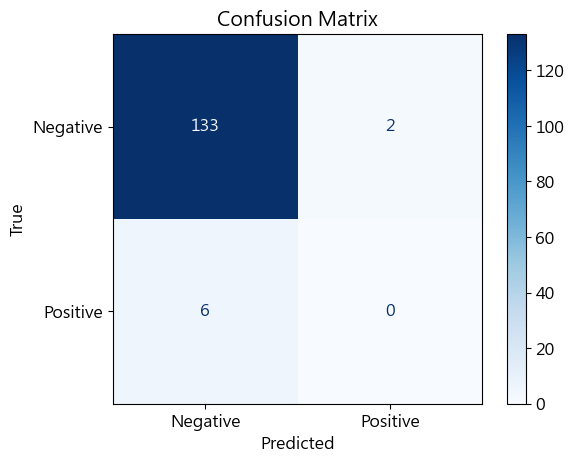

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       135
     Class 1       0.00      0.00      0.00         6

    accuracy                           0.94       141
   macro avg       0.48      0.49      0.49       141
weighted avg       0.92      0.94      0.93       141



In [27]:
# fit the original dataset with optimized model
model = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
ConfusionMatrix(X_train_Original_Selected, X_test_Original_Selected, y_train_Original, y_test_Original,model)